# Import libraries

In [237]:
import numpy as np
import matplotlib.pyplot as plt
import lasio

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage  

import pandas as pd

# Supprt functions

In [47]:
def ismember(A, B):
    return [ np.sum(a == B) for a in A ]

# Loading las file

In [25]:
dataFolderName = "las_files"
lasFileName    = "2F19_08-_1_jwl_JWL_FILE_243939324.las"
fullFileName = dataFolderName + '/' + lasFileName
las = lasio.read(fullFileName);

In [27]:
las.keys()

['DEPTH',
 'DTC',
 'DTS',
 'GR',
 'K',
 'KTH',
 'RD',
 'RM',
 'RS',
 'RTHK',
 'RTHU',
 'RUK',
 'TH',
 'UR']

In [291]:
selectedLogsName = ['GR', 'DTC', 'DTS', 'K', 'RD']
minDepth     =  0
maxDepth     =  10000
nullValue    = -999.2500 

depth = las['DEPTH'];
selectedDepth = np.logical_and(depth >= minDepth, depth <= maxDepth);

selectedLogs = np.array([1 if head in selectedLogs else 0 for head in las.keys()])
selectedLogsIx = np.array([ind for ind, head in enumerate(las.keys()) if head in selectedLogsName])
selectedLogsIx

# Remove nans
selectedData = las.data
selectedData = las.data[:, selectedLogsIx]


indNotNan = ~np.isnan(selectedData).any(axis=1)
selectedData = selectedData[indNotNan];
depth = depth[indNotNan]; 

normalizedData = normalize(selectedData, axis = 0)

# Some statistics
nLogs = len(selectedLogsName)
nFacies = 5
nPoints = normalizedData.shape[0]


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


In [292]:
# PCA
dataToAnalyze = normalizedData

pca = PCA(n_components=2).fit_transform(normalizedData)
#print(pca.explained_variance_ratio_)

kmeans = KMeans(init='k-means++', n_clusters=nFacies, n_init=10);
kmeans.fit(pca)
labels = kmeans.predict(pca)

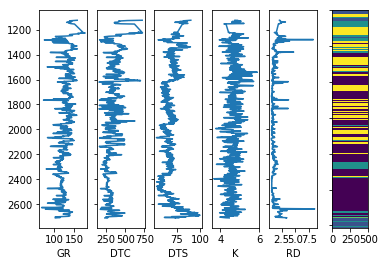

In [330]:
# Some plotting

imageToShow = np.tile(labels, (500, 1)).T

fig = plt.figure()

for index in range(nLogs):
    plt.subplot(1, nLogs+1, index+1)
    ax = plt.plot(selectedData[:,index], depth)
    plt.gca().invert_yaxis()
    plt.xlabel(selectedLogsName[index])
    if(index>0):
        plt.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            labelright =False,      # ticks along the bottom edge are off
            labelleft =False,         # ticks along the top edge are off
            ) 

axResult = plt.subplot(1, nLogs+1, nLogs+1)
plt.imshow(imageToShow);
#plt.gca().invert_yaxis()
plt.tick_params(
    axis='both',            # changes apply to the x-axis
    which='both',           # both major and minor ticks are affected
    labelright =False,      # ticks along the bottom edge are off
    labelleft =False,       # ticks along the top edge are off
    ) 

In [325]:
# Get tables of facies properties

meanTable = np.zeros([nFacies,nLogs])
varTable = np.zeros([nFacies,nLogs])

for faciesInd in range(nFacies):
    for logInd in range(nLogs):
        selectedDataInd = labels == faciesInd
        meanTable[faciesInd, logInd] = np.mean(selectedData[selectedDataInd,logInd])
        varTable[faciesInd, logInd] = np.var(selectedData[selectedDataInd,logInd])
        

meanTablePD = pd.DataFrame(meanTable, columns = selectedLogsName) 
varTablePD = pd.DataFrame(varTable, columns = selectedLogsName)  

print("Mean Summary Table")
print(meanTablePD)

print("Variance Summary Table")
print(varTablePD)

Mean Summary Table
           GR         DTC        DTS         K        RD
0  122.043088  284.964635  64.621992  4.606331  0.885126
1  127.172537  342.589459  79.355027  4.621202  2.537237
2  120.651861  296.474497  69.776172  4.603296  1.535702
3  110.558273  221.149273  72.636364  4.555455  7.028845
4  141.422342  434.733998  70.425422  4.788780  0.915009
Variance Summary Table
           GR          DTC         DTS         K        RD
0  117.389020  1946.268195   25.972278  0.088143  0.022677
1  232.101792  9210.128856  112.377880  0.086189  0.262056
2  180.027201  4331.613280   44.283305  0.085756  0.049605
3  264.791627  1033.066062   95.045375  0.117565  1.441799
4   63.925749  4455.174252   29.378378  0.087692  0.041717


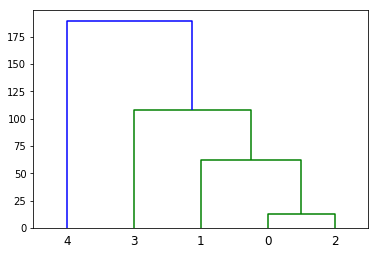

In [295]:
linked = linkage(meanTablePD, 'ward')
dendrogram(linked,  
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()  

In [328]:
upscalingMatrix = np.zeros([nPoints, nFacies])
upscalingMatrix[:,0] = labels;

for upscaleInd in range(0,nFacies-1):
    left  = linked[upscaleInd,0];
    right = linked[upscaleInd,1];
    newLables   =  upscalingMatrix[:,upscaleInd]
    nLeft  = np.sum(upscaleInd == left)
    nRight = np.sum(upscaleInd == right)
    
    if (nLeft > nRight):
        newLables[newLables == right] = left
        linked[linked == nFacies+upscaleInd]= left
    else:
        newLables[newLables == left] = right
        linked[linked == nFacies+upscaleInd]= right
        
    #upscalingMatrix[:,upscaleInd+1] = newLables
    


[0. 1. 3. 4.]


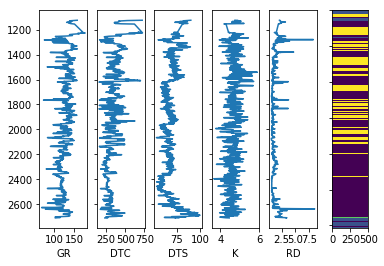

In [329]:
# Some plotting

labelsToUse = upscalingMatrix[:,0]
print(np.unique(labelsToUse))
imageToShow = np.tile(labelsToUse, (500, 1)).T

fig = plt.figure()

for index in range(nLogs):
    plt.subplot(1, nLogs+1, index+1)
    ax = plt.plot(selectedData[:,index], depth)
    plt.gca().invert_yaxis()
    plt.xlabel(selectedLogsName[index])
    if(index>0):
        plt.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            labelright =False,      # ticks along the bottom edge are off
            labelleft =False,         # ticks along the top edge are off
            ) 

axResult = plt.subplot(1, nLogs+1, nLogs+1)
plt.imshow(imageToShow);
#plt.gca().invert_yaxis()
plt.tick_params(
    axis='both',            # changes apply to the x-axis
    which='both',           # both major and minor ticks are affected
    labelright =False,      # ticks along the bottom edge are off
    labelleft =False,       # ticks along the top edge are off
    ) 

In [ ]:
np.unique()